In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from cnn_model import CNN_Ieeg_Model
from lstm_model import LSTM_Ieeg_Model,LSTM_Ieeg_Model_2
from ann_baseline import Baseline_ANN
from transformer_model import TransformerClassifier
from cnn_lstm import CNN_LSTM_Model, ParallelCNNLSTMModel, LSTM_CNN,ParallelCNNTransformerModel
from utils import get_loaders, import_checkpoint, save_checkpoint
import torch
import multiprocessing
import mlflow
import mlflow.pytorch
import torch
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import psutil
import mlflow.pytorch
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math


# MLFlow Set up

In [2]:
os.environ['AWS_ACCESS_KEY_ID'] = 'dIgexhE2iDrGls2qargL'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'IzEzgQpztotDnrIInJdUfUIYngpjJoT18d0FDZf7'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9000'
os.environ['MLFLOW_S3_IGNORE_TLS'] = 'true'
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"
mlflow.set_tracking_uri("http://localhost:5000")

print('tracking uri:', mlflow.get_tracking_uri())

tracking uri: http://localhost:5000


# Parameter setting

In [14]:
# Configuration
DATA_DIR = '../data/data_normalized_exp2'
SEQ_LENGTH = 1000
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
EXPERIMENT_NAME = "IEEG_Classification_TNN_CNN"
# RUN_NAME = "CNN"
PIN_MEMORY = True
LOAD_MODEL = False
NUM_WORKERS = multiprocessing.cpu_count()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = SEQ_LENGTH
NUM_CLASSES = 5
CHECKPOINTS_PATH = '../models/checkpoints'

# Previous Steps Before Training

In [4]:
def get_model_size(model):
    param_size = 0
    buffer_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024 ** 2
    return size_all_mb

In [5]:
def train_model(model: nn.Module, train_loader: DataLoader, optimizer: optim.Optimizer, 
                criterion: nn.Module, num_epochs: int, device: torch.device, save_checkpoint_interval: int = 10, 
                early_stopping_patience: int = 15, checkpoint_dir: str = '../models/checkpoints', accumulation_steps: int = 2,
                cnn=False, model_name='CNN'):
    """
    Train a deep learning model with the given parameters and log metrics to MLflow.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        optimizer (optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function.
        num_epochs (int): Number of epochs to train.
        device (torch.device): Device to use for training (CPU or GPU).
        save_checkpoint_interval (int, optional): Interval for saving checkpoints. Default is 10.
        early_stopping_patience (int, optional): Patience for early stopping. Default is 5.
        checkpoint_dir (str, optional): Directory to save checkpoints. Default is 'checkpoints'.
        accumulation_steps (int, optional): Number of steps to accumulate gradients before updating weights. Default is 2.
    """
    scaler = GradScaler()  # For mixed precision training
    best_loss = float('inf')  # Track the best loss for early stopping
    patience_counter = 0  # Counter for early stopping

    # Ensure checkpoint directory exists
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true_train = []
        y_pred_train = []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        optimizer.zero_grad()  # Reset gradients at the start of each epoch

        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():  # Mixed precision training
                if not cnn:
                    outputs = model(inputs)
                else:
                    outputs, _= model(inputs)
                loss = criterion(outputs, labels.squeeze())

            scaler.scale(loss).backward()  # Backpropagation

            scaler.step(optimizer)  # Update weights
            scaler.update()
            optimizer.zero_grad()  # Reset gradients after updating weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(labels.squeeze().cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

            avg_loss = running_loss / (batch_idx + 1)
            train_accuracy = accuracy_score(y_true_train, y_pred_train)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='weighted', zero_division=0)

            progress_bar.set_postfix(loss=avg_loss, accuracy=train_accuracy, precision=precision, recall=recall, f1=f1)

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", avg_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
        mlflow.log_metric("train_precision", precision, step=epoch)
        mlflow.log_metric("train_recall", recall, step=epoch)
        mlflow.log_metric("train_f1", f1, step=epoch)

        # Save checkpoint every 'save_checkpoint_interval' epochs
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{model_name}.pth.tar')
            save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}, checkpoint_path)
            mlflow.log_artifact(checkpoint_path, artifact_path="checkpoints")

        # Early stopping
        if round(avg_loss,4) < best_loss:
            best_loss = round(avg_loss,4)
            patience_counter = 0  # Reset counter if we get a new best loss
            # print(f"Best Loss:{best_loss}")
            # print(f"AVG Loss:{avg_loss}")
            # print(f"patience_counter:{patience_counter}")


        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            mlflow.log_param("epochs_actual", (epoch+1))

            break

        # Clear CUDA cache after each epoch
        torch.cuda.empty_cache()

    # Clear CUDA cache at the end of training
    torch.cuda.empty_cache()

In [6]:

def evaluate_model(model: nn.Module, test_loader: DataLoader, dataset: Dataset, device: torch.device, 
                   img_path: str, run_name: str, batch_size: int = 16, cnn=False):
    """
    Evaluate a deep learning model and log metrics to MLflow.

    Args:
        model (nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for the test data.
        dataset (Dataset): The dataset containing the test data.
        device (torch.device): Device to use for evaluation (CPU or GPU).
        img_path (str): Path to save the confusion matrix image.
        run_name (str): Name of the MLflow run.
        batch_size (int, optional): Batch size for evaluation. Default is 16.
    """
    model.eval()
    y_true_test = []
    y_pred_test = []
    feature_maps = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            if not cnn: 
                outputs = model(inputs)

            else:
                outputs, feature_map = model(inputs)
                feature_maps.append([fm.cpu() for fm in feature_map])  # Move feature maps to CPU to free GPU memory

            _, predicted = torch.max(outputs, 1)
            y_true_test.extend(labels.squeeze().cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

            # Clear cache to free up memory
            torch.cuda.empty_cache()

    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='weighted', zero_division=0)

    print(f'Accuracy of the model on the test data: {test_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", precision)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_f1", f1)

    # Confusion matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    cm_df = pd.DataFrame(cm, index=dataset.label_encoder.classes_, columns=dataset.label_encoder.classes_)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    img_file = os.path.join(img_path, f"confusion_matrix_{run_name}.png")
    plt.savefig(img_file)
    mlflow.log_artifact(img_file)
    plt.close()

    # Save feature maps and labels to file
    if cnn:
        feature_maps_file = os.path.join(img_path, f"feature_maps_{run_name}.pt")
        torch.save((feature_maps, y_true_test, y_pred_test), feature_maps_file)
    # mlflow.log_artifact(feature_maps_file, artifact_path="feature_maps")

    return y_true_test, y_pred_test


In [7]:

def plot_feature_maps(feature_maps_file: str, sample_index: int, img_path: str, run_name: str, dpi: int = 300, linewidth: float = 0.5):
    """
    Plot the feature maps for a specified sample from Conv1D layers.

    Args:
        feature_maps_file (str): Path to the file containing the saved feature maps and labels.
        sample_index (int): Index of the sample to plot the feature maps for.
        img_path (str): Path to save the feature map images.
        run_name (str): Name of the MLflow run.
        dpi (int, optional): Resolution of the saved images. Default is 300.
        linewidth (float, optional): Line width for the feature map plots. Default is 0.5.
    """
    # Load feature maps and labels from file
    feature_maps, y_true_test, y_pred_test = torch.load(feature_maps_file)
    
    # Check if the sample index is valid
    if sample_index >= len(feature_maps):
        raise ValueError(f"Sample index {sample_index} is out of range. There are only {len(feature_maps)} samples.")

    # Get the feature maps for the specified sample
    sample_feature_maps = feature_maps[sample_index]
    true_label = y_true_test[sample_index]
    predicted_label = y_pred_test[sample_index]
    
    # Plot each feature map
    for layer_idx, feature_map in enumerate(sample_feature_maps):
        num_feature_maps = feature_map.shape[0]  # Number of feature maps
        
        # Determine the grid size for subplots
        grid_size = int(np.ceil(np.sqrt(num_feature_maps)))
        
        plt.figure(figsize=(15, 15))
        for i in range(num_feature_maps):
            plt.subplot(grid_size, grid_size, i + 1)
            plt.plot(feature_map[i].cpu().numpy(), linewidth=linewidth)
            plt.axis('off')
        
        plt.suptitle(f'Feature Maps for Layer {layer_idx + 1} (True: {true_label}, Pred: {predicted_label})')
        img_file = os.path.join(img_path, f"feature_maps_layer_{layer_idx + 1}_{run_name}_sample_{sample_index}.png")
        plt.savefig(img_file, dpi=dpi)
        plt.close()
        
        print(f'Saved feature maps for layer {layer_idx + 1} to {img_file}')


# Training CNN

In [8]:
train_loader, test_loader, dataset = get_loaders(data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                        pin_memory=PIN_MEMORY, test_size=0.2, seq_length=SEQ_LENGTH, model_type="cnn")

KeyboardInterrupt: 

In [9]:
# Assuming you have already defined train_loader
for inputs, labels in train_loader:
    print("Shape of inputs:", inputs.shape)
    print("Shape of labels:", labels.shape)
    break  # Remove this line if you want to see shapes of more items

Shape of inputs: torch.Size([64, 1, 5000])
Shape of labels: torch.Size([64])


In [10]:
model = CNN_Ieeg_Model(SEQ_LENGTH, NUM_CLASSES).to(DEVICE)
model

CNN_Ieeg_Model(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList(
    (0): Linear(in_features=159744, out_features=1024, bias=True)
    (1): Linear(in_features=1024, 

In [11]:
if LOAD_MODEL == True: # existe un modelo entrenado preliminarmente
        import_checkpoint(torch.load('D:/Dropbox/PUJ/Subjects/Graduate/2023-1/Deep Learning/Lessons/9 - 24.04.23/my_checkpoint.pth.tar'), model)
                                      
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion =  nn.CrossEntropyLoss()  
scaler = torch.cuda.amp.GradScaler()

In [12]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/9', creation_time=1716795170067, experiment_id='9', last_update_time=1716795170067, lifecycle_stage='active', name='IEEG_Classification_Arch_CNN_Hybrid', tags={}>

In [13]:
# Train and Evaluate the Model with MLflow
run_name = "CNN_Experiment"
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters
    mlflow.log_param("epochs", NUM_EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("model", "CNN")
    mlflow.log_param("input_size", SEQ_LENGTH)
    mlflow.log_param("num_classes", NUM_CLASSES)
    mlflow.log_dict(dataset.get_class_mapping(), "class_mapping.json")

    # Train and Evaluate the Model
    train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS, DEVICE, early_stopping_patience=20,save_checkpoint_interval=10, checkpoint_dir=CHECKPOINTS_PATH, cnn=True, model_name="CNN")
    evaluate_model(model, test_loader, dataset, DEVICE, img_path='../plots', run_name=run_name, cnn=True)

    # Log the model
    mlflow.pytorch.log_model(model, "model_CNN")

2024/05/27 03:07:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 11/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 21/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 26/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 27/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 28/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 29/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 30/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 31/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 32/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 33/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 34/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 35/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 36/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 37/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 38/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 39/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 40/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 41/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 42/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 43/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 44/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 45/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 46/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 47/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 48/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 49/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 50/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Accuracy of the model on the test data: 0.94%
Precision: 0.9450, Recall: 0.9443, F1 Score: 0.9434


2024/05/27 03:23:21 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 03:23:21 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [9]:
# Example usage
plot_feature_maps(feature_maps_file='../plots/feature_maps_CNN_Experiment.pt', 
                  sample_index=0, 
                  img_path='../plots/feature_maps', 
                  run_name='example_run')

Saved feature maps for layer 1 to ../plots/feature_maps/feature_maps_layer_1_example_run_sample_0.png
Saved feature maps for layer 2 to ../plots/feature_maps/feature_maps_layer_2_example_run_sample_0.png
Saved feature maps for layer 3 to ../plots/feature_maps/feature_maps_layer_3_example_run_sample_0.png
Saved feature maps for layer 4 to ../plots/feature_maps/feature_maps_layer_4_example_run_sample_0.png


# ANN Simple 

In [46]:
train_loader, test_loader, dataset = get_loaders(data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                        pin_memory=PIN_MEMORY, test_size=0.2, seq_length=SEQ_LENGTH, model_type="mlp")

In [49]:
model = Baseline_ANN(INPUT_SIZE, NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model

Baseline_ANN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5000, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): ReLU()
  (output_layer): Linear(in_features=64, out_features=5, bias=True)
)

In [50]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/8', creation_time=1716783309844, experiment_id='8', last_update_time=1716783309844, lifecycle_stage='active', name='IEEG_Classification_Architecture_Comp', tags={}>

In [52]:
# Train and Evaluate the Model with MLflow
run_name = "MLP_Experiment"
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters
    mlflow.log_param("epochs", NUM_EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("model", "CNN")
    mlflow.log_param("input_size", SEQ_LENGTH)
    mlflow.log_param("num_classes", NUM_CLASSES)
    mlflow.log_dict(dataset.get_class_mapping(), "class_mapping.json")

    # Train and Evaluate the Model
    train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS, DEVICE, save_checkpoint_interval=10, early_stopping_patience=40, checkpoint_dir=CHECKPOINTS_PATH, cnn=False, model_name="MLP")
    evaluate_model(model, test_loader, dataset, DEVICE, img_path='../plots', run_name=run_name, cnn=False)

    # Log the model
    mlflow.pytorch.log_model(model, "model_MLP")

2024/05/27 00:08:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 11/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 21/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 26/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 27/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 28/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 29/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 30/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 31/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 32/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 33/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 34/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 35/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 36/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 37/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 38/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 39/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 40/40:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Accuracy of the model on the test data: 0.68%
Precision: 0.6688, Recall: 0.6756, F1 Score: 0.6712


2024/05/27 00:10:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 00:10:45 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# Train LSTM

In [15]:
train_loader, test_loader, dataset = get_loaders(data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                        pin_memory=PIN_MEMORY, test_size=0.2, seq_length=SEQ_LENGTH, model_type="cnn")

In [25]:
from torchview import draw_graph

In [ ]:
# Assuming you have already defined train_loader
for inputs, labels in train_loader:
    print("Shape of inputs:", inputs.shape)
    print("Shape of labels:", labels.shape)
    break  # Remove this line if you want to see shapes of more items

In [32]:
batch = next(iter(train_loader))
batch[0].shape

torch.Size([64, 1, 1000])

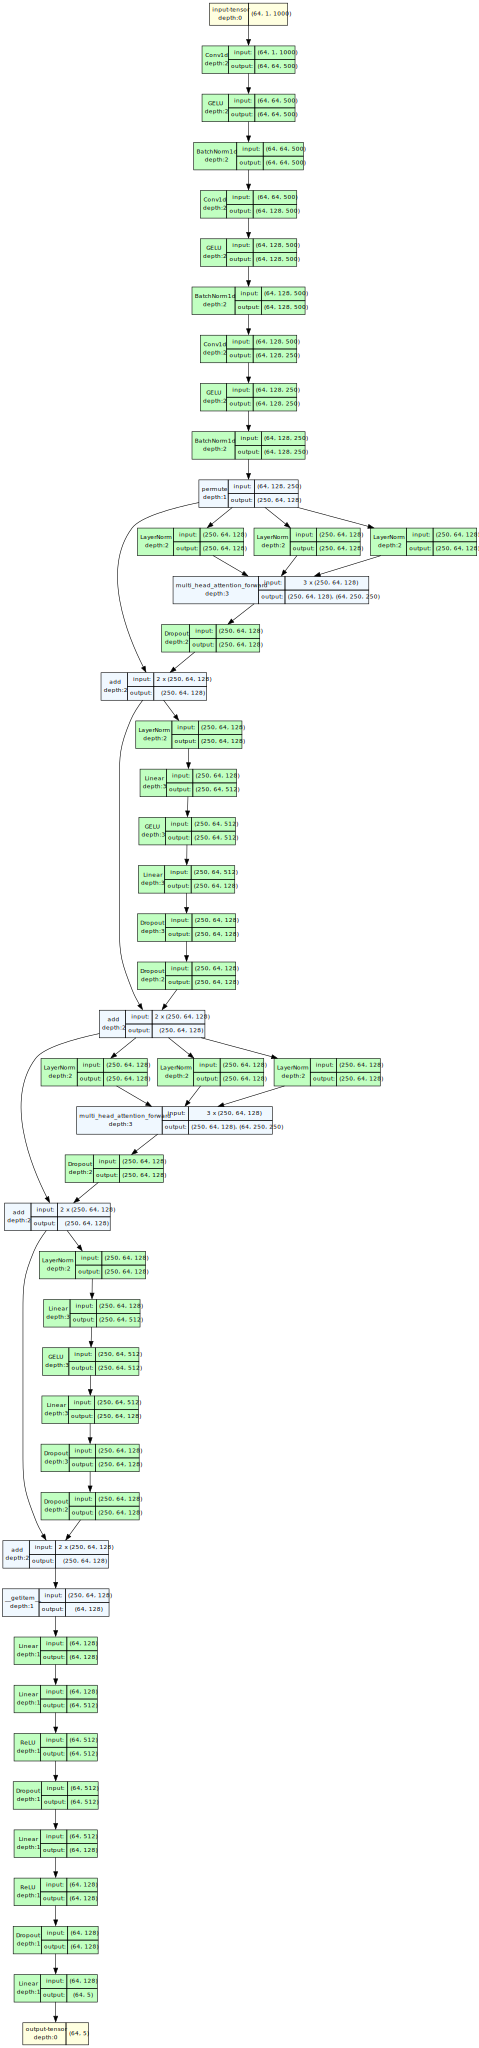

In [33]:
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(BATCH_SIZE,1, 1000), device='meta')
model_graph.visual_graph

In [22]:
from torchviz import make_dot
batch = next(iter(test_loader))
yhat = model(batch.text) # Give dummy batch to forward().
make_dot(yhat,params=dict(model.named_parameters()))

AttributeError: 'list' object has no attribute 'text'

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class TransformerStem(nn.Module):
    def __init__(self, in_channels=1, out_channels=16):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels // 2, kernel_size=10, stride=2, bias=False, padding=4)
        self.act1 = nn.GELU()
        self.bn1 = nn.BatchNorm1d(out_channels // 2)

        self.conv2 = nn.Conv1d(out_channels // 2, out_channels, kernel_size=3, stride=1, bias=False, padding=1)
        self.act2 = nn.GELU()
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=2, bias=False, padding=1)
        self.act3 = nn.GELU()
        self.bn3 = nn.BatchNorm1d(out_channels)

        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, bias=qkv_bias)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0])
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

class ParallelTransformerModel(nn.Module):
    def __init__(self, input_size: int, num_classes: int, 
                 transformer_dim: int = 128, num_heads: int = 4, 
                 transformer_depth: int = 2,
                 fc_neurons: list = [512, 128],
                 dropout: float = 0.3, activation: nn.Module = nn.ReLU()):
        super(ParallelTransformerModel, self).__init__()

        # Transformer
        self.transformer_stem = TransformerStem(in_channels=1, out_channels=transformer_dim)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(dim=transformer_dim, num_heads=num_heads, dropout=dropout) for _ in range(transformer_depth)]
        )
        self.fc_transformer = nn.Linear(transformer_dim, 128)

        # Fully connected layers for output
        self.transformer_output_size = 128  # Size after the fc_transformer layer

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(self.transformer_output_size, fc_neurons[0]))
        for i in range(len(fc_neurons) - 1):
            self.fc_layers.append(nn.Linear(fc_neurons[i], fc_neurons[i + 1]))
        self.output_layer = nn.Linear(fc_neurons[-1], num_classes)

        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Transformer path
        x_transformer = self.transformer_stem(x)
        x_transformer = x_transformer.permute(2, 0, 1)  # Adjust shape for Transformer
        for block in self.transformer_blocks:
            x_transformer = block(x_transformer)
        x_transformer = x_transformer[-1]  # Take the last output of Transformer
        x_transformer = self.fc_transformer(x_transformer)

        # Fully connected layers
        x = x_transformer
        for fc in self.fc_layers:
            x = self.activation(fc(x))
            x = self.dropout(x)
        
        x = self.output_layer(x)
        return x


# Model parameters
# Model parameters
input_size = SEQ_LENGTH  # Use the sequence length provided by your dataset
num_classes = 5  # Number of classes for classification
conv_filters = [64, 128]  # Reduced number of filters to save memory
transformer_dim = 128  # Smaller transformer dimension
num_heads = 4  # Fewer attention heads
transformer_depth = 2  # Fewer transformer layers
fc_neurons = [512, 128]  # Reduced fully connected layer sizes
dropout = 0.3  # Dropout rate

# Instantiate the model

# Instantiate the model
model = ParallelTransformerModel(
    input_size=input_size,
    num_classes=num_classes,
    transformer_dim=transformer_dim,
    num_heads=num_heads,
    transformer_depth=transformer_depth,
    fc_neurons=fc_neurons,
    dropout=dropout,
    activation=nn.ReLU()
).to(DEVICE)



In [17]:
print(f'Model size: {get_model_size(model):.3f} MB')
model

Model size: 2.365 MB


ParallelTransformerModel(
  (transformer_stem): TransformerStem(
    (conv1): Conv1d(1, 64, kernel_size=(10,), stride=(2,), padding=(4,), bias=False)
    (act1): GELU(approximate='none')
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (act2): GELU(approximate='none')
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (act3): GELU(approximate='none')
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=False)
      )
      (n

In [ ]:
model = LSTM_Ieeg_Model(device=DEVICE,
                        input_size=1, 
                        num_classes=NUM_CLASSES, 
                        lstm_layers=2, 
                        lstm_h_size=128,
                        fc_neurons=[1024,256], 
                        bidirectional=False).to(DEVICE)
print(f'Model size: {get_model_size(model):.3f} MB')
model

Model size: 2.270 MB


LSTM_Ieeg_Model(
  (activation): ReLU()
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=5, bias=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
)

In [18]:
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion =  nn.CrossEntropyLoss()  

In [19]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/10', creation_time=1716929166769, experiment_id='10', last_update_time=1716929166769, lifecycle_stage='active', name='IEEG_Classification_TNN_CNN', tags={}>

In [20]:

# Train and Evaluate the Model with MLflow
run_name = "TNN"
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters
    mlflow.log_param("epochs", NUM_EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("input_size", SEQ_LENGTH)
    mlflow.log_param("num_classes", NUM_CLASSES)
    mlflow.log_dict(dataset.get_class_mapping(), "class_mapping.json")

    # Train and Evaluate the Model
    train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS, DEVICE, 
                save_checkpoint_interval=10, checkpoint_dir=CHECKPOINTS_PATH, 
                model_name="LSTM", early_stopping_patience=40, cnn=False)
    evaluate_model(model, test_loader, dataset, DEVICE, img_path='../plots', run_name=run_name)

    # Log the model
    mlflow.pytorch.log_model(model, "model_LSTM")

2024/05/28 18:05:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/10:   0%|          | 0/820 [00:00<?, ?batch/s]

/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 2/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 3/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 4/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 5/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 6/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 7/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 8/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 9/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Epoch 10/10:   0%|          | 0/820 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Evaluating:   0%|          | 0/205 [00:00<?, ?batch/s]

/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Accuracy of the model on the test data: 0.97%
Precision: 0.9706, Recall: 0.9704, F1 Score: 0.9701


2024/05/28 18:11:44 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/28 18:11:44 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [14]:
# Assuming you have already defined train_loader
for inputs, labels in train_loader:
    print("Shape of inputs:", inputs.shape)
    print("Shape of labels:", labels.shape)
    break  # Remove this line if you want to see shapes of more items



Shape of inputs: torch.Size([64, 1, 5000])
Shape of labels: torch.Size([64])


# Hybrid model CNN + LSTM

In [14]:
train_loader, test_loader, dataset = get_loaders(data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                        pin_memory=PIN_MEMORY, test_size=0.2, seq_length=SEQ_LENGTH, model_type="cnn")

In [20]:
model = CNN_LSTM_Model(  input_size=SEQ_LENGTH, 
                        num_classes=NUM_CLASSES, ).to(DEVICE)
print(f'Model size: {get_model_size(model):.3f} MB')
model

Model size: 81.943 MB


CNN_LSTM_Model(
  (cnn_head): CNN_Head(
    (conv_layers): ModuleList(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (bn_layers): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(512, 64, num_layers=4, batch_first=True)
  (fc_layers)

In [16]:
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion =  nn.CrossEntropyLoss()  

In [17]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/9', creation_time=1716795170067, experiment_id='9', last_update_time=1716795170067, lifecycle_stage='active', name='IEEG_Classification_Arch_CNN_Hybrid', tags={}>

In [18]:

# Train and Evaluate the Model with MLflow
run_name = "CNN_LSTM_Experiment"
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters
    mlflow.log_param("epochs", NUM_EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("model", "CNN_LSTM")
    mlflow.log_param("input_size", SEQ_LENGTH)
    mlflow.log_param("num_classes", NUM_CLASSES)
    mlflow.log_dict(dataset.get_class_mapping(), "class_mapping.json")

    # Train and Evaluate the Model
    train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS, DEVICE, 
                save_checkpoint_interval=10, checkpoint_dir=CHECKPOINTS_PATH, 
                model_name="CNN_LSTM", early_stopping_patience=10, cnn=False)
    evaluate_model(model, test_loader, dataset, DEVICE, img_path='../plots', run_name=run_name)

    # Log the model
    mlflow.pytorch.log_model(model, "model_CNN_LSTM")

2024/05/27 08:02:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 11/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 21/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 26/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 27/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 28/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 29/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 30/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 31/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 32/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 33/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 34/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 35/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 36/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 37/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 38/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 39/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 40/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 41/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 42/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 43/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 44/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 45/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 46/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 47/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 48/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 49/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Early stopping at epoch 49


Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

Accuracy of the model on the test data: 0.94%
Precision: 0.9397, Recall: 0.9360, F1 Score: 0.9341


2024/05/27 08:10:46 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 08:10:46 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# Parallel CNN LSTM

In [8]:
train_loader, test_loader, dataset = get_loaders(data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                        pin_memory=PIN_MEMORY, test_size=0.2, seq_length=SEQ_LENGTH, model_type="cnn")

In [21]:
model = ParallelCNNLSTMModel(input_size=SEQ_LENGTH, 
                            num_classes=NUM_CLASSES,
                            input_size_lstm=1,
                            # conv_filters=[64,128,256],
                            # fc_neurons=[1024,128],
                            # lstm_hidden_size=64,
                            lstm_num_layers=3
                        ).to(DEVICE)
print(f'Model size: {get_model_size(model):.3f} MB')
model

Model size: 627.849 MB


ParallelCNNLSTMModel(
  (cnn_head): CNN_Head(
    (conv_layers): ModuleList(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (bn_layers): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc_lst

In [10]:
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion =  nn.CrossEntropyLoss() 

In [11]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/9', creation_time=1716795170067, experiment_id='9', last_update_time=1716795170067, lifecycle_stage='active', name='IEEG_Classification_Arch_CNN_Hybrid', tags={}>

In [12]:

# Train and Evaluate the Model with MLflow
run_name = "P_CNN_LSTM_Experiment"
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters
    mlflow.log_param("epochs", NUM_EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("model", "P_CNN_LSTM")
    mlflow.log_param("input_size", SEQ_LENGTH)
    mlflow.log_param("num_classes", NUM_CLASSES)
    mlflow.log_dict(dataset.get_class_mapping(), "class_mapping.json")

    # Train and Evaluate the Model
    train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS, DEVICE, 
                save_checkpoint_interval=10, checkpoint_dir=CHECKPOINTS_PATH, 
                model_name="P_CNN_LSTM", early_stopping_patience=10, cnn=False)
    evaluate_model(model, test_loader, dataset, DEVICE, img_path='../plots', run_name=run_name)

    # Log the model
    mlflow.pytorch.log_model(model, "model_P_CNN_LSTM")

2024/05/27 02:39:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 11/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 21/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 26/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 27/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 28/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 29/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 30/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 31/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 32/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 33/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 34/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 35/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 36/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 37/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 38/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 39/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 40/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 41/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 42/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 43/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 44/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 45/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 46/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 47/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 48/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 49/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 50/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Accuracy of the model on the test data: 0.95%
Precision: 0.9488, Recall: 0.9470, F1 Score: 0.9462


2024/05/27 03:04:53 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 03:04:53 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# LSTM + CNN

In [9]:
train_loader, test_loader, dataset = get_loaders(data_dir=DATA_DIR, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                                        pin_memory=PIN_MEMORY, test_size=0.2, seq_length=SEQ_LENGTH, model_type="seq")

In [22]:
model = LSTM_CNN(input_size=1,
                   seq_length=SEQ_LENGTH, 
                 hidden_size=64,
                 num_layers=4, 
                num_classes=NUM_CLASSES,
                ).to(DEVICE)
print(f'Model size: {get_model_size(model):.3f} MB')
model

Model size: 627.475 MB


LSTM_CNN(
  (lstm): LSTM(1, 64, num_layers=4, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=159744, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_fea

In [11]:
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion =  nn.CrossEntropyLoss() 

In [12]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/9', creation_time=1716795170067, experiment_id='9', last_update_time=1716795170067, lifecycle_stage='active', name='IEEG_Classification_Arch_CNN_Hybrid', tags={}>

In [13]:

# Train and Evaluate the Model with MLflow
run_name = "LSTM_CNN_Experiment"
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters
    mlflow.log_param("epochs", NUM_EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("input_size", SEQ_LENGTH)
    mlflow.log_param("num_classes", NUM_CLASSES)
    mlflow.log_dict(dataset.get_class_mapping(), "class_mapping.json")

    # Train and Evaluate the Model
    train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS, DEVICE, 
                save_checkpoint_interval=10, checkpoint_dir=CHECKPOINTS_PATH, 
                model_name="LSTM_CNN", early_stopping_patience=10, cnn=False)
    evaluate_model(model, test_loader, dataset, DEVICE, img_path='../plots', run_name=run_name)

    # Log the model
    mlflow.pytorch.log_model(model, "model_LSTM_CNN")

2024/05/27 03:26:48 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 11/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 21/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 26/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 27/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 28/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 29/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 30/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 31/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 32/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 33/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 34/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 35/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 36/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 37/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 38/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 39/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 40/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Checkpoint saved successfully.


Epoch 41/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 42/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 43/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Early stopping at epoch 43


Evaluating:   0%|          | 0/41 [00:00<?, ?batch/s]

/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Accuracy of the model on the test data: 0.87%
Precision: 0.8562, Recall: 0.8666, F1 Score: 0.8562


2024/05/27 03:50:31 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 03:50:31 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
